In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')

from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

import unet
%matplotlib inline

/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cjw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/cjw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['depth'] = 96
params['nchannels'] = 1
params['channels'] = [1]
params['nepochs'] = [1]
params['batchsize'] = [8]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[32,3], [64, 3], [128, 3], [192, 3]]
params['dec_sizes'] = [[128,3], [64, 3], [32, 3], [params['nchannels'], 3]]
params['droprate'] = 0.25
params['stdev'] = 0.08

In [4]:

tf.reset_default_graph()
u = unet.unet3d(params)


In [5]:
#u.read_images('/media/cjw/Data/Nuclei.tif')
u.read_mm('/media/cjw/Data/nuclei.mm', shape=(720, 256, 256, 96, 2))
#u.x = u.x[:,:,:,:,:]
u.x.shape

(720, 256, 256, 96, 2)

In [6]:
#a = u.get_batch(4, augment=True)
#ab = u.augment_batch(a)
#ab.shape

In [7]:
# from scipy.ndimage import rotate
# # angle = 90*np.random.randint(0,4)
# # print(angle)
# # s = a[2]
# #ar = rotate(a, 270, (1,2), reshape=False, order=1)
# plt.subplot(2,1,1)
# plt.imshow(a[1,:,:,47,0])
# plt.subplot(2,1,2)
# plt.imshow(a[1,:,:,47,1])

In [8]:

images = tf.placeholder(tf.float32, (None, 256, 256, 96, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, 256, 256, 96, params['nchannels']))

In [9]:
enc = u.create_encoder(images, True)

[32, 3]
[64, 3]
[128, 3]
[192, 3]


In [10]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

3 Tensor("dropout_5/mul:0", shape=(?, 32, 32, 12, 128), dtype=float32)
2 Tensor("dropout_3/mul:0", shape=(?, 64, 64, 24, 64), dtype=float32)
1 Tensor("dropout_1/mul:0", shape=(?, 128, 128, 48, 32), dtype=float32)
0 Tensor("Placeholder:0", shape=(?, 256, 256, 96, 1), dtype=float32)
mmse loss ()


In [11]:
u.set_validation(20)

In [12]:
sess = tf.Session()

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
u.stdev = 0.04
u.learning_rate = 0.0001

13043.174 18374.262 0.0 1.0


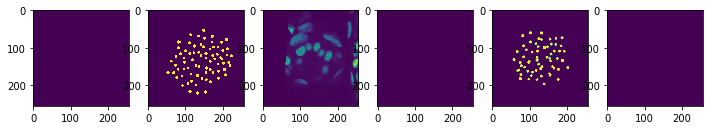

0 13043.174 5.900784492492676 0


KeyboardInterrupt: 

In [19]:
vx = np.expand_dims(u.xvalid[:,:,:,:,0], -1)
vm = np.expand_dims(u.xvalid[:,:,:,:,1], -1) 

for i in range(20000):
    t1 = time.time()
    batch = u.get_batch(8, augment=False)
    bx = np.expand_dims(batch[:,:,:,:,0], -1)
    bm = np.expand_dims(batch[:,:,:,:,1], -1)
    _, res, err = sess.run([u.opt, u.decoder_sigmoid, u.loss], feed_dict={images:bx, masks:bm})
    if i % 40 == 0:
        vres, verr = sess.run([u.decoder_sigmoid, u.loss],
                               feed_dict={images:vx, masks:vm})

        zm = vres[0,:,:,:,0].argmax(axis=(-1))
        print(err, verr, vres[0,:,:,:,0].min(), vres[0,:,:,:,0].max())
        #print(zm)
    
        plt.figure(figsize=(12,2))
        plt.subplot(1,6,1)
        plt.imshow(res[0,:,:,:,0].max(axis=(-1)))
        plt.subplot(1,6,2)
        plt.imshow(bm[0,:,:,:,0].max(axis=(-1)))
        plt.subplot(1,6,3)
        plt.imshow(bx[0,:,:,32,0])
        plt.subplot(1,6,4)
        plt.imshow(vres[0,:,:,:,0].max(axis=(-1)))
        plt.subplot(1,6,5)
        plt.imshow(vm[0,:,:,:,0].max(axis=(-1)))
        plt.subplot(1,6,6)
        plt.imshow(zm/zm.max()) #[0,:,:,32,0])
        plt.show()
    t2 = time.time()
    if i % 4 == 0:
        print(i, err, (t2 - t1), len(u.used))
        #print(zm)

In [19]:
vres.shape

(4, 256, 256, 96, 1)

(array([1.25819389e+08, 9.50000000e+01, 5.80000000e+01, 5.10000000e+01,
        5.90000000e+01, 7.00000000e+01, 1.49000000e+02, 1.80000000e+02,
        1.58000000e+02, 8.91100000e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

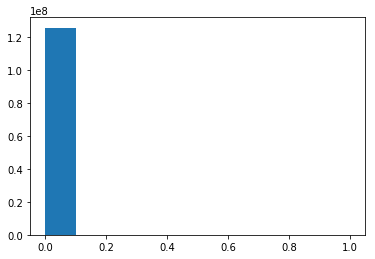

In [32]:
plt.hist(res.reshape(-1))

In [206]:
u.create_loss(masks)
ss = sess.run(u.loss, feed_dict={images:yy, masks:bb})

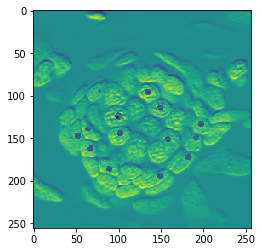

In [208]:
ss.shape
plt.imshow(ss[0,:,:,44,0])

In [219]:
rt = y[0,:,:,:,:]
from scipy.ndimage import rotate

res = rotate(rt, 45, (0, 1), order=2)

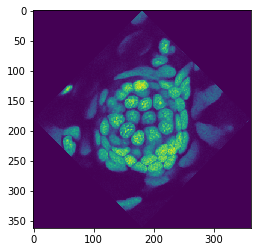

In [220]:
plt.imshow(res[:,:,44,0])

In [17]:
u.x.shape
u.used = None

In [9]:
import pickle
from scipy.ndimage import rotate


def augment(b, da = 1):
    mm = np.memmap('/media/cjw/Data/nuclei.mm', dtype=np.float32,
               mode='r+', shape=(720, 256, 256, 96, 2))
    nr = b.shape[0]
    d = dict()
    counter = 0
    for i in range(nr):
        print(i)
        s = b[i]  # this loses the first dimension
        mm[counter] = s
        counter += 1
        print(counter)
        angle = 0
        while angle < 360:
            angle += da
            mm[counter] = rotate(s, angle, (0,1), reshape=False, order=1)
            counter += 1
            print(counter)
            
        mm.flush()
    del mm
        
augment(u.x, 18)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
1
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
2
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
3
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
4
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
5
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
6
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
7
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
8
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
9
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
10
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
11
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
12
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270

IndexError: index 720 is out of bounds for axis 0 with size 720

In [11]:
mm = np.memmap('/media/cjw/Data/nuclei.mm', dtype=np.float32,
               mode='r', shape=(720, 256, 256, 96, 2))

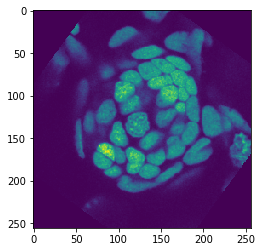

In [16]:
plt.imshow(mm[-19,:,:,34,0])